In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [2]:
cd ../../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [3]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [4]:
#load in diffmat data
atlas = ants.image_read('/mmfs1/data/pijarj/BC-ORG-Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [5]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [6]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
122


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 122/122 [00:18<00:00,  6.69it/s]


(122, 699)

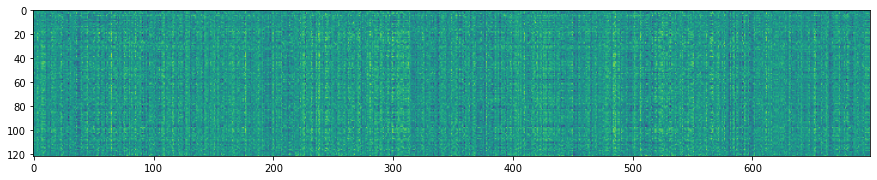

In [8]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)
gene_fmri_corr.shape

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(gene_fmri_corr.transpose())
gene_fmri_corr_PCA = principalComponents.transpose()

In [10]:
principalComponents.shape

(699, 10)

In [11]:
gene_fmri_corr_PCA.shape

(10, 699)

In [12]:
col_id = 0
Y_total = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_total = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_total = ~np.isnan(Y_total)[:,col_id]
Y_use_total = Y_total[good_subjects_total,col_id] 
X_use_total = gene_fmri_corr_PCA[:,good_subjects_total]
X_use_total = X_use_total.transpose()
regression_total =  linear_model.LinearRegression(normalize=True)
linear_regression_total = regression_total.fit(X_use_total,Y_use_total) 
Y_use_hat_total = linear_regression_total.predict(X_use_total)

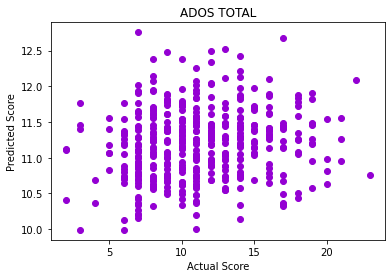

In [13]:
#scatter plot for ados_total
plt.scatter(Y_use_total,Y_use_hat_total,color='darkviolet')
plt.title('ADOS TOTAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [14]:
col_id = 1
Y_comm = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_comm = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_comm = ~np.isnan(Y_comm)[:,col_id]
Y_use_comm = Y_comm[good_subjects_comm,col_id] 
X_use_comm = gene_fmri_corr_PCA[:,good_subjects_comm]
X_use_comm = X_use_comm.transpose()
regression_comm =  linear_model.LinearRegression(normalize=True)
linear_regression_comm = regression_comm.fit(X_use_comm,Y_use_comm) 
Y_use_hat_comm = linear_regression_comm.predict(X_use_comm)

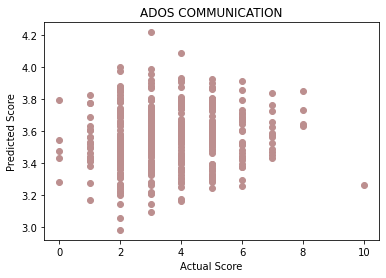

In [15]:
#scatter plot for ados_comm
plt.scatter(Y_use_comm,Y_use_hat_comm,color='rosybrown')
plt.title('ADOS COMMUNICATION')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [16]:
col_id = 2
Y_social = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_social = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_social = ~np.isnan(Y_social)[:,col_id]
Y_use_social = Y_social[good_subjects_social,col_id] 
X_use_social = gene_fmri_corr_PCA[:,good_subjects_social]
X_use_social = X_use_social.transpose()
regression_social =  linear_model.LinearRegression(normalize=True)
linear_regression_social = regression_social.fit(X_use_social,Y_use_social) 
Y_use_hat_social = linear_regression_social.predict(X_use_social)

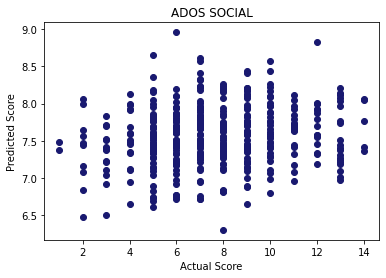

In [17]:
#scatter plot for ados_social
plt.scatter(Y_use_social,Y_use_hat_social,color='midnightblue')
plt.title('ADOS SOCIAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [18]:
col_id = 3
Y_rrb = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_rrb = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_rrb = ~np.isnan(Y_rrb)[:,col_id]
Y_use_rrb = Y_rrb[good_subjects_rrb,col_id] 
X_use_rrb = gene_fmri_corr_PCA[:,good_subjects_rrb]
X_use_rrb = X_use_rrb.transpose()
regression_rrb =  linear_model.LinearRegression(normalize=True)
linear_regression_rrb = regression_rrb.fit(X_use_rrb,Y_use_rrb) 
Y_use_hat_rrb = linear_regression_rrb.predict(X_use_rrb)

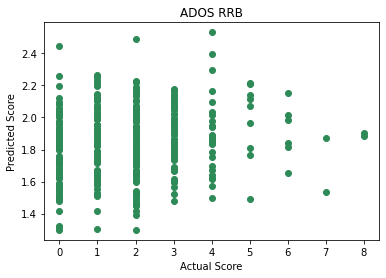

In [19]:
#scatter plot for ados_rrb
plt.scatter(Y_use_rrb,Y_use_hat_rrb,color='seagreen')
plt.title('ADOS RRB')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [20]:
#variance explained for ados_total
from sklearn.metrics import explained_variance_score
total = explained_variance_score(Y_use_total,Y_use_hat_total)*100
print(total)

1.6081560680456852


In [21]:
#variance explained for ados_comm
from sklearn.metrics import explained_variance_score
comm = explained_variance_score(Y_use_comm,Y_use_hat_comm)*100
print(comm)

1.3333681683158183


In [22]:
#variance explained for ados_social
from sklearn.metrics import explained_variance_score
social = explained_variance_score(Y_use_social,Y_use_hat_social)*100
print(social)

2.2771170391405193


In [23]:
#variance explained for ados_rrb
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use_rrb,Y_use_hat_rrb)*100
print(rrb)

1.9914103783606363


Text(0.5, 0, 'Symptom')

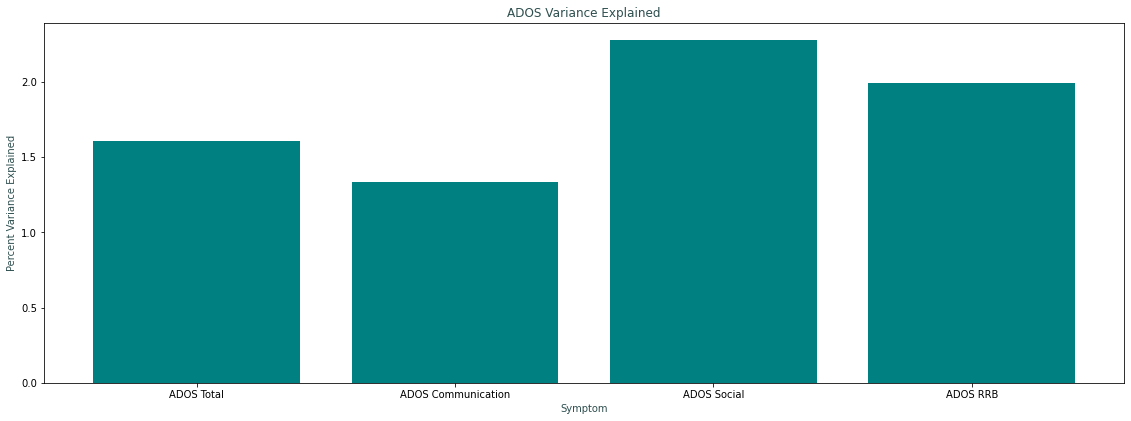

In [26]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ADOS Total','ADOS Communication','ADOS Social','ADOS RRB']
var_explained = total, comm, social, rrb
plt.bar(ados_label,var_explained,color='teal')
plt.title('ADOS Variance Explained',color='darkslategrey')
plt.ylabel('Percent Variance Explained',color='darkslategrey')
plt.xlabel('Symptom',color='darkslategrey')

In [27]:
#correlation coefficents for ados_total
coefficient_total = regression_total.coef_
labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
print(column_total)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_total[i]}')

ados_total

PC1,-0.19296150472144974
PC2,0.3290588581926443
PC3,-0.838862357769784
PC4,0.05926094699047103
PC5,-0.5487559493868978
PC6,0.6258309655612228
PC7,0.06376440893505507
PC8,0.2720678702238778
PC9,-2.528267408206154
PC10,1.0446423882440192


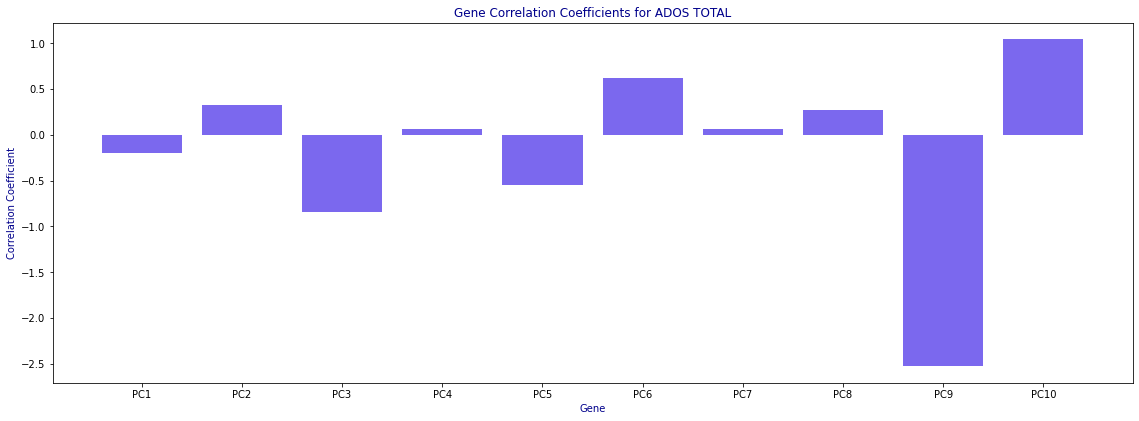

In [57]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_total,color='mediumslateblue')
plt.title('Gene Correlation Coefficients for ADOS TOTAL',color='darkblue')
plt.ylabel('Correlation Coefficient',color='darkblue')
plt.xlabel('Gene',color='darkblue')
plt.show()

In [60]:
#correlation coefficents for ados_comm
coefficient_comm = regression_comm.coef_
print(column_comm)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_comm[i]}')

ados_comm

PC1,-0.24907122721880798
PC2,-0.027521652643427454
PC3,-0.24752846974426626
PC4,-0.23986240428511832
PC5,-0.07652952790999755
PC6,0.32690390375835987
PC7,0.30340323780465295
PC8,0.36223033011196787
PC9,-0.38197507819936294
PC10,-0.2578527755329295


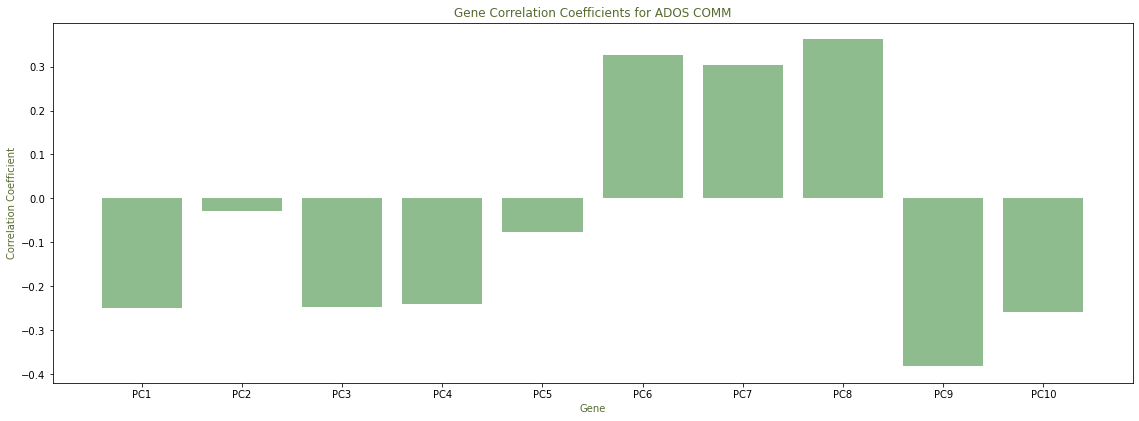

In [61]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_comm,color='darkseagreen')
plt.title('Gene Correlation Coefficients for ADOS COMM',color='darkolivegreen')
plt.ylabel('Correlation Coefficient',color='darkolivegreen')
plt.xlabel('Gene',color='darkolivegreen')
plt.show()

In [62]:
#correlation coefficents for ados_social
coefficient_social = regression_social.coef_
print(column_social)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_social[i]}')

ados_social

PC1,0.03184220199160095
PC2,0.4132357594254877
PC3,-0.6116451556450575
PC4,0.5465786218107391
PC5,-0.1408688890575963
PC6,0.3179568360879565
PC7,-0.1969850074767694
PC8,-0.21975917278785187
PC9,-1.945312854490622
PC10,1.3483251459568202


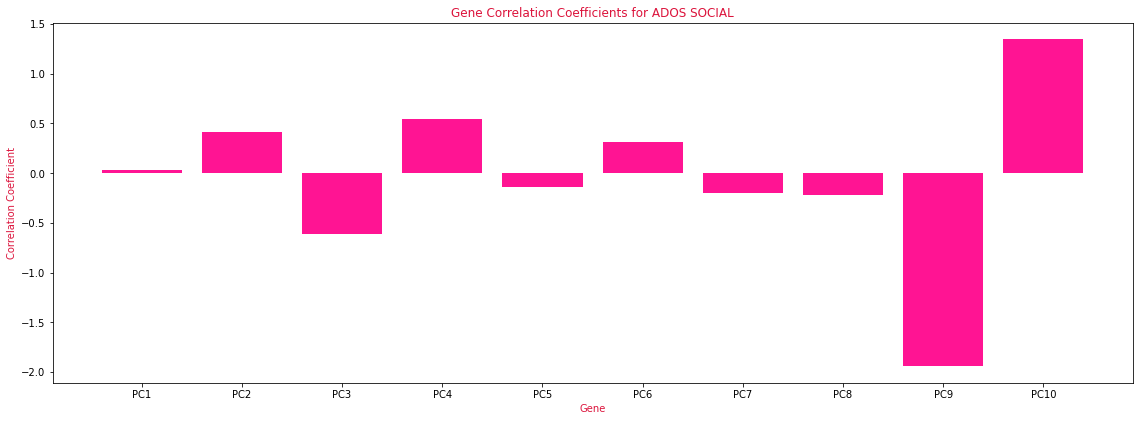

In [64]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_social,color='deeppink')
plt.title('Gene Correlation Coefficients for ADOS SOCIAL',color='crimson')
plt.ylabel('Correlation Coefficient',color='crimson')
plt.xlabel('Gene',color='crimson')
plt.show()

In [66]:
#correlation coefficents for ados_rrb
coefficient_rrb = regression_rrb.coef_
print(column_rrb)
print()
for i in range(0,10):
    print(f'{labels[i]},{coefficient_rrb[i]}')

ados_rrb

PC1,-0.08093241120909211
PC2,0.21153782499688997
PC3,-0.570083184338502
PC4,-0.11953031133961171
PC5,-0.011095011566399061
PC6,0.31409695986626346
PC7,-0.11382006628078208
PC8,-0.27160676266099015
PC9,-0.8593297310736526
PC10,-0.1250035286694559


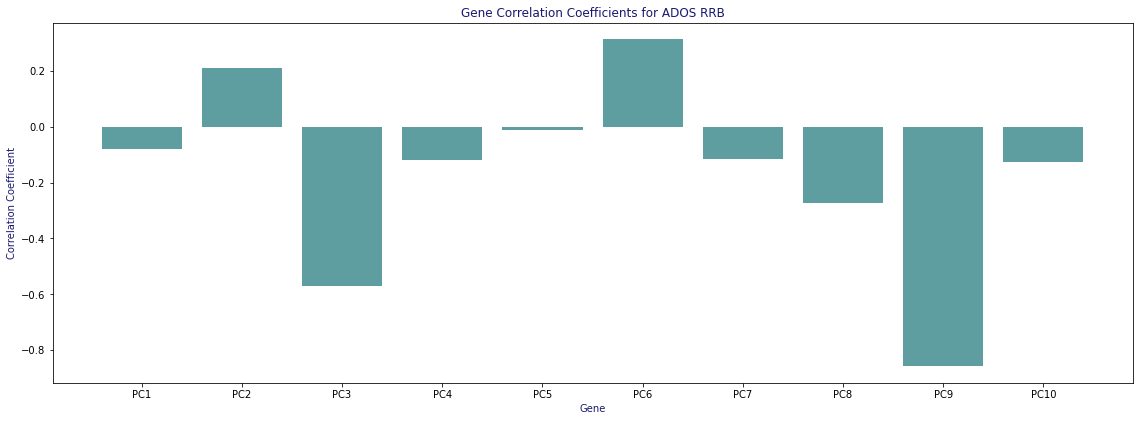

In [68]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_rrb,color='cadetblue')
plt.title('Gene Correlation Coefficients for ADOS RRB',color='midnightblue')
plt.ylabel('Correlation Coefficient',color='midnightblue')
plt.xlabel('Gene',color='midnightblue')
plt.show()

In [70]:
#significance of coefficients for ados_total
print('ADOS_TOTAL')
X_total = X_use_total.copy()
Y_total = Y_use_total.copy()
X_total = sm.add_constant(X_total)
print(X_total.shape)
print(Y_total.shape)

est_total = sm.OLS(Y_total, X_total)
est2_total = est_total.fit()
print(est2_total.summary())

ADOS_TOTAL
(429, 11)
(429,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6832
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.740
Time:                        15:18:48   Log-Likelihood:                -1186.3
No. Observations:                 429   AIC:                             2395.
Df Residuals:                     418   BIC:                             2439.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1921   

In [71]:
def plot_errorbar_from_table(est2_total,labels):
    coef_total = est2_total.params[1::]
    ci_total = est2_total.conf_int()[1::,:]
    ci_rel_total = abs(np.vstack((coef_total,coef_total)).transpose() - ci_total)
    ci_rel_total = ci_rel_total.transpose()
    xs_total = np.arange(len(coef_total))

    plt.figure(figsize=(15,5))
    plt.bar(xs_total,coef_total,color='thistle')
    plt.errorbar(xs_total,coef_total,ci_rel_total,fmt='r ',capsize=10,ecolor='indigo')
    plt.xticks(xs_total,labels=labels);

Text(0.5, 0, 'Principal Component')

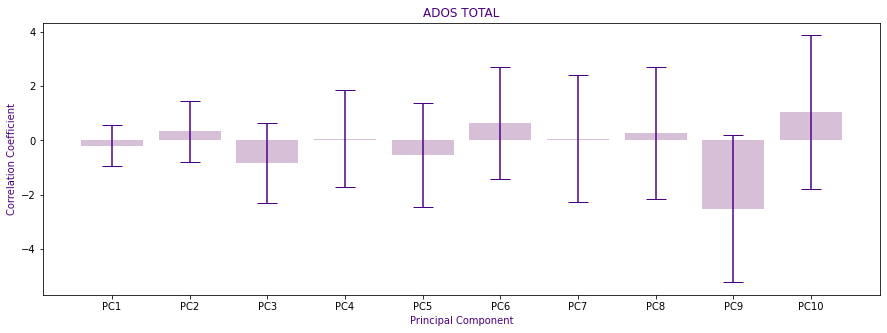

In [72]:
plot_errorbar_from_table(est2_total,labels)
plt.title('ADOS TOTAL',color='indigo')
plt.ylabel('Correlation Coefficient',color='indigo')
plt.xlabel('Principal Component',color='indigo')

In [67]:
#significance of coefficients for ados_comm
print('ADOS_COMM')
X_comm = X_use_comm.copy()
Y_comm = Y_use_comm.copy()
X_comm = sm.add_constant(X_comm)

est_comm = sm.OLS(Y_comm, X_comm)
est2_comm = est_comm.fit()
print(est2_comm.summary())

ADOS_COMM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.5406
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.861
Time:                        15:18:26   Log-Likelihood:                -771.86
No. Observations:                 411   AIC:                             1566.
Df Residuals:                     400   BIC:                             1610.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5468      0.080     44.54

In [68]:
def plot_errorbar_from_table(est2_comm,labels):
    coef_comm = est2_comm.params[1::]
    ci_comm = est2_comm.conf_int()[1::,:]
    ci_rel_comm = abs(np.vstack((coef_comm,coef_comm)).transpose() - ci_comm)
    ci_rel_comm = ci_rel_comm.transpose()
    xs_comm = np.arange(len(coef_comm))

    plt.figure(figsize=(15,5))
    plt.bar(xs_comm,coef_comm,color='lightgrey')
    plt.errorbar(xs_comm,coef_comm,ci_rel_comm,fmt='r ',capsize=10,ecolor='darkslategray')
    plt.xticks(xs_comm,labels=labels);

Text(0.5, 0, 'Principal Component')

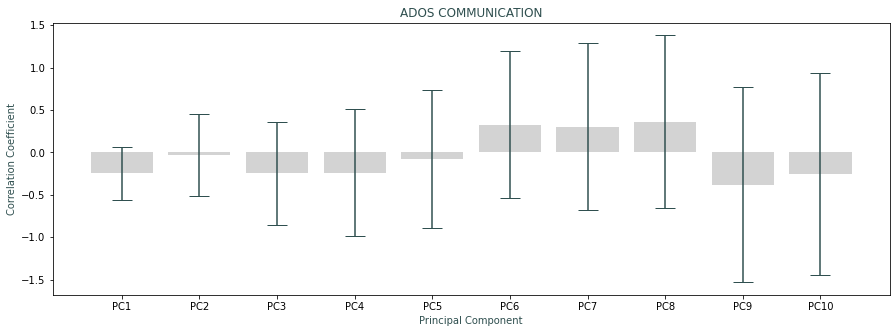

In [69]:
plot_errorbar_from_table(est2_comm,labels)
plt.title('ADOS COMMUNICATION',color='darkslategray')
plt.ylabel('Correlation Coefficient',color='darkslategray')
plt.xlabel('Principal Component',color='darkslategray')

In [35]:
#significance of coefficients for ados_social
print('ADOS_SOCIAL')
X_social = X_use_social.copy()
Y_social = Y_use_social.copy()
X_social = sm.add_constant(X_social)

est_social = sm.OLS(Y_social, X_social)
est2_social = est_social.fit()
print(est2_social.summary())

ADOS_SOCIAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9344
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.501
Time:                        14:30:02   Log-Likelihood:                -993.52
No. Observations:                 412   AIC:                             2009.
Df Residuals:                     401   BIC:                             2053.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5650      0.136     55.

In [65]:
def plot_errorbar_from_table(est2_social,labels):
    coef_social = est2_social.params[1::]
    ci_social = est2_social.conf_int()[1::,:]
    ci_rel_social = abs(np.vstack((coef_social,coef_social)).transpose() - ci_social)
    ci_rel_social = ci_rel_social.transpose()
    xs_social = np.arange(len(coef_social))

    plt.figure(figsize=(15,5))
    plt.bar(xs_social,coef_social,color='skyblue')
    plt.errorbar(xs_social,coef_social,ci_rel_social,fmt='r ',capsize=10,ecolor='midnightblue')
    plt.xticks(xs_social,labels=labels);

Text(0.5, 0, 'Principal Component')

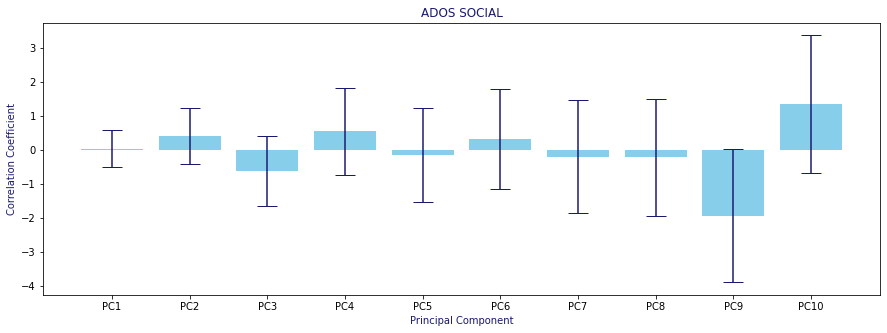

In [66]:
plot_errorbar_from_table(est2_social,labels)
plt.title('ADOS SOCIAL',color='midnightblue')
plt.ylabel('Correlation Coefficient',color='midnightblue')
plt.xlabel('Principal Component',color='midnightblue')

In [45]:
#significance of coefficients for ados_rrb
print('ADOS_RRB')
X_rrb = X_use_rrb.copy()
Y_rrb = Y_use_rrb.copy()
X_rrb = sm.add_constant(X_rrb)

est_rrb = sm.OLS(Y_rrb, X_rrb)
est2_rrb = est_rrb.fit()
print(est2_rrb.summary())

ADOS_RRB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7396
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.687
Time:                        14:31:12   Log-Likelihood:                -687.48
No. Observations:                 375   AIC:                             1397.
Df Residuals:                     364   BIC:                             1440.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8482      0.080     23.041

In [61]:
def plot_errorbar_from_table(est2_rrb,labels):
    coef_rrb = est2_rrb.params[1::]
    ci_rrb = est2_rrb.conf_int()[1::,:]
    ci_rel_rrb = abs(np.vstack((coef_rrb,coef_rrb)).transpose() - ci_rrb)
    ci_rel_rrb = ci_rel_rrb.transpose()
    xs_rrb = np.arange(len(coef_rrb))

    plt.figure(figsize=(15,5))
    plt.bar(xs_rrb,coef_rrb,color='lightgreen')
    plt.errorbar(xs_rrb,coef_rrb,ci_rel_rrb,fmt='r ',capsize=10,ecolor='darkgreen')
    plt.xticks(xs_rrb,labels=labels);

Text(0.5, 0, 'Principal Component')

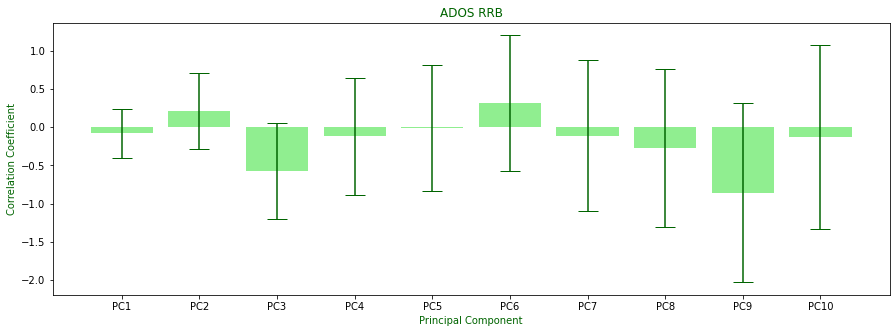

In [63]:
plot_errorbar_from_table(est2_rrb,labels)
plt.title('ADOS RRB',color='darkgreen')
plt.ylabel('Correlation Coefficient',color='darkgreen')
plt.xlabel('Principal Component',color='darkgreen')